In [1]:
import numpy as np
# Astropy is 
from astropy.io import fits

# Numpy is a powerful package for numerical analysis.
import numpy as np

# Matplotlib is the most popular Python plotting package.
import matplotlib.pyplot as plt
import glob

from scipy.optimize import curve_fit

In [3]:
#Getting images
flat1 = fits.getdata('/astro/users/lexie98/Documents/CCDLab/flat295(2).FIT').astype(np.int32)
flat2 = fits.getdata('/astro/users/lexie98/Documents/CCDLab/flat29.5(3).FIT').astype(np.int32)
bias1 = fits.getdata('/astro/users/lexie98/Documents/CCDLab/bias.FIT').astype(np.int32)
bias2 = fits.getdata('/astro/users/lexie98/Documents/CCDLab/bias2.FIT').astype(np.int32)

In [4]:
#Getting mean values
mean_f1 = np.mean(flat1)
print(mean_f1)

mean_f2 = np.mean(flat2)
print(mean_f2)

mean_b1 = np.mean(bias1)
print(mean_b1)

mean_b2 = np.mean(bias2)
print(mean_b2)

#Getting standard deviations from the difference between images
sigma_f1f2 = np.std(flat1 - flat2)
print(sigma_f1f2)

sigma_b1b2 = np.std(bias1 - bias2)
print(sigma_b1b2)

#Evaluating the gain
gain = ((mean_f1 + mean_f2) - (mean_b1 + mean_b2)) / ((sigma_f1f2 ** 2) - (sigma_b1b2 ** 2))
print(gain)

6739.779149178236
6457.8470888489155
112.93477545623665
117.78965914856326
210.36141915678945
51.590842543065584
0.31177698106978


In [5]:
#Read Noise
read_noise = (gain * sigma_b1b2) / np.sqrt(2)

print(read_noise)

11.373697415213934


In [21]:
#Linearity; getting the fits files as a handy dandy array
flat_list = glob.glob('/astro/users/lexie98/Documents/CCDLab/Flats/flat*.FIT')


In [7]:
# These are empty lists (arrays) to store the exposure times and mean counts
exp_times = []
means = []

for filename in flat_list:
    # Open the FITS file
    hdu = fits.open(filename)
    
    exptime = hdu[0].header['exposure']
    print('Exposure time {} sec'.format(exptime))
    
    # This will append the exposure time for each image to the array
    exp_times.append(exptime)
    
    # Same for mean counts
    mean_counts = np.mean(hdu[0].data)
    print('Mean counts: {:.2f}\n'.format(mean_counts))
    means.append(mean_counts)

# Convert to Numpy arrays so they can be sorted
exp_times = np.array(exp_times)
means = np.array(means)

# Sort by exposure time so the plot looks correct
time_sort = np.argsort(exp_times)
exp_times = exp_times[time_sort]
means = means[time_sort]

Exposure time 0.14 sec
Mean counts: 145.51

Exposure time 0.56 sec
Mean counts: 228.51

Exposure time 1.13 sec
Mean counts: 353.10

Exposure time 2.25 sec
Mean counts: 612.57

Exposure time 4.5 sec
Mean counts: 1039.42

Exposure time 9.0 sec
Mean counts: 1810.71

Exposure time 18.0 sec
Mean counts: 4067.03

Exposure time 27.0 sec
Mean counts: 6337.47

Exposure time 36.0 sec
Mean counts: 8638.10

Exposure time 45.0 sec
Mean counts: 10728.44

Exposure time 54.0 sec
Mean counts: 12096.95

Exposure time 63.0 sec
Mean counts: 14132.56

Exposure time 72.0 sec
Mean counts: 14518.43

Exposure time 81.0 sec
Mean counts: 15436.37

Exposure time 90.0 sec
Mean counts: 21168.47

Exposure time 0.28 sec
Mean counts: 172.71

Exposure time 135.0 sec
Mean counts: 30470.05

Exposure time 144.0 sec
Mean counts: 34397.28

Exposure time 126.0 sec
Mean counts: 33771.87

Exposure time 153.0 sec
Mean counts: 34785.47

Exposure time 117.0 sec
Mean counts: 33911.78

Exposure time 99.0 sec
Mean counts: 31771.47



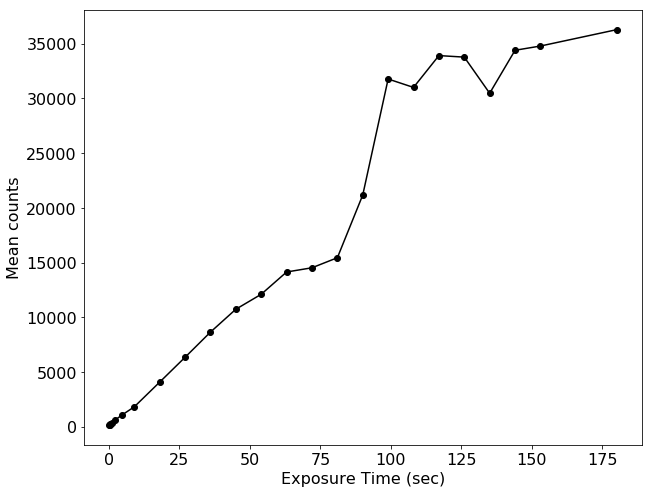

In [8]:
plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 16

plt.plot(exp_times, means, '-ko')
plt.xlabel('Exposure Time (sec)')
plt.ylabel('Mean counts')
plt.show()

In [9]:
#Dark current

#List of temperatures in celsius
t_cel = np.array([-15., -10., -8., -6., -4.2, -2.3, 0., 2., 
                3.6, 5.8, 8.2, 10., 12.8, 16.2, 20.])
#List of ADUs to complement the temperature array
adu = np.array([13, 15, 16, 17, 19, 22, 24, 28, 32, 37, 
                43, 50, 62, 89, 139])

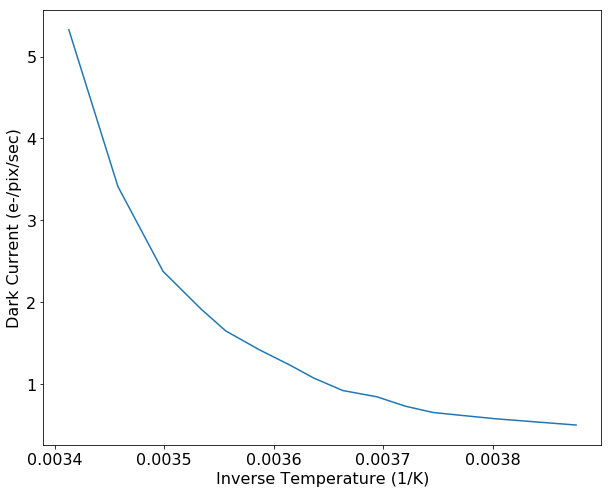

In [10]:
#converting celsius to kelvin
t_kel = t_cel + 273

#converting ADU to electrons per second
electrons = 2.3 * adu
electrons_per_sec = electrons / 60

#Plotting dark current as a function of electrons per pixel per second
plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 16
t = np.arange(200,300,10)

plt.plot(1 /t_kel, electrons_per_sec)
plt.xlabel('Inverse Temperature (1/K)')
plt.ylabel('Dark Current (e-/pix/sec)')
plt.show()

In [20]:
# The Boltzmann constant
k_b = 8.6175e-5

#Equation for dark current
def dark_current(t_k, alpha, e_g):
    """
    Analytic expression for dark current as a function of temperature.
    
    Parameters
    ----------
    t_k : numpy.ndarray
        Temperature in Kelvin
    alpha : float
        Constant coefficient in front of exponential funtion.
    e_g : float
        Band gap energy in eV.
    
    Returns
    -------
    dark_current : numpy.ndarray
        Dark current in electrons/pixel/second.
    """
    dark_current = alpha * np.exp(-e_g / (2 * k_b * t_k))
    return dark_current


In [16]:
#inverting temp and electrons per second
t_0 = t_kel[-1]
d_0 = electrons_per_sec[-1]

#setting an initial constant and Eg
alpha_0 =  d_0 / np.exp(-1.1 / (2 * k_b * t_0))
e_g_0 = 1.1

In [17]:
#fitting the curve witht the constants Eg and alpha
p_opt, p_cov = curve_fit(dark_current, t_kel, electrons_per_sec, p0=[alpha_0, e_g_0])

# Errors in the fit
sig_alpha, sig_e_g = np.sqrt(np.diag(p_cov))

In [18]:
#Curve fit values for Eg and alpha
alpha_fit, e_g_fit = p_opt
print(alpha_fit)
print(e_g_fit)

152176394354.8298
1.2192320840791062


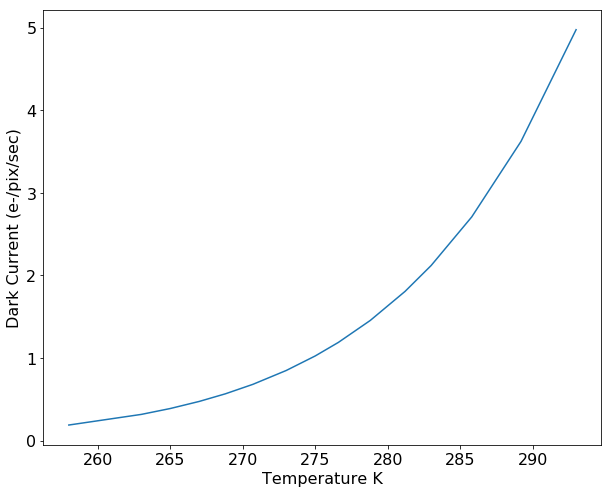

In [19]:
#Plotting the dark current with the fitted Eg and alpha values as a function of temperature
plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 16
t = np.arange(200,300,10)

plt.plot(t_kel, dark_current(t_kel,alpha_fit, e_g_fit))
plt.xlabel('Temperature K')
plt.ylabel('Dark Current (e-/pix/sec)')
plt.show()